In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [29]:
from pandas import Series

In [30]:
import ystockquote

In [31]:
from datetime import datetime, timedelta, timezone

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [33]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

In [34]:
AAPL_data = ystockquote.get_historical_prices('IBM', '2010-01-01', '2017-12-31')

In [35]:
df = pd.DataFrame(AAPL_data).transpose()

In [36]:
df.head()

,Adj Close,Close,High,Low,Open,Volume
2010-01-04,111.405,132.449997,132.970001,130.850006,131.179993,6155300
2010-01-05,110.059232,130.850006,131.850006,130.100006,131.679993,6841400
2010-01-06,109.344283,130.00,131.490005,129.809998,130.679993,5605300
2010-01-07,108.965786,129.550003,130.25,128.910004,129.869995,5840600
2010-01-08,110.059232,130.850006,130.919998,129.050003,129.070007,4197200


In [37]:
df['Date'] = df.apply(lambda row: datetime.strptime(row.name, '%Y-%m-%d'),
                      axis=1)

In [38]:
df['Close'] = pd.to_numeric(df['Close'], errors='ignore')

In [39]:
df.drop(axis=1, labels=[col for col in df.columns if col not in ['Close', 'Date']], inplace=True)

In [40]:
df.set_index('Date', inplace=True)
df.head(3)

,Close
Date,
2010-01-04,132.449997
2010-01-05,130.850006
2010-01-06,130.000000


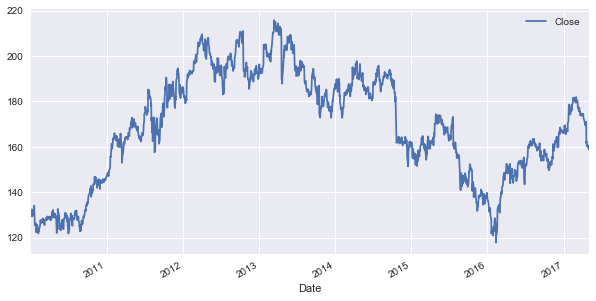

In [41]:
df.plot(figsize=(10,5))

## A rolling forecast scenario will be used, also called walk-forward model validation.

In [42]:
df['Close 1'] = df['Close'].shift(1)

In [43]:
df['Close -1'] = df['Close'].shift(-1)

In [44]:
df.fillna(0, inplace=True)

In [45]:
df['Difference'] = df['Close -1'] - df['Close']

In [46]:
df.head()

,Close,Close 1,Close -1,Difference
Date,,,,
2010-01-04,132.449997,0.000000,130.850006,-1.599991
2010-01-05,130.850006,132.449997,130.000000,-0.850006
2010-01-06,130.000000,130.850006,129.550003,-0.449997
2010-01-07,129.550003,130.000000,130.850006,1.300003
2010-01-08,130.850006,129.550003,129.479996,-1.370010


In [47]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_X = scaler.fit_transform(df['Difference'].values.reshape(-1, 1))

In [48]:
# split data into train and test
length_of_df = len(df)
train_size = 0.75

to_idx = int(length_of_df*train_size)
train, test = scaled_X[0:to_idx], scaled_X[to_idx:]

In [49]:
print(train.shape)
print(test.shape)

(1383, 1)
(462, 1)


In [50]:
def create_trainable_data(from_data, sequence_length=100):
    result = []
    y_result = []
    for index in range(len(from_data) - sequence_length):
        result.append(from_data[index: index + sequence_length, 0])
        y_result.append(from_data[index + sequence_length, 0])
    result = np.array(result)
    y_result = np.array(y_result)
    return result, y_result

In [51]:
X_train, y_train = create_trainable_data(train)
X_test, y_test = create_trainable_data(test)
print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)

X train shape:  (1283, 100)
y train shape:  (1283,)


In [52]:
# the second row's last item...
X_train[1, 99]

0.86913560807017354

In [53]:
# ...should be the first predicted value
y_train[0]

0.86913560807017354

In [58]:
features = X_train.shape[1]
model = Sequential()
model.add(Embedding(300, features))
model.add(LSTM(features, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='tanh'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=8,
          epochs=10,
          validation_data=(X_test, y_test),
          verbose=2)

Train on 1283 samples, validate on 362 samples
Epoch 1/10
22s - loss: 0.6622 - acc: 7.7942e-04 - val_loss: 0.3718 - val_acc: 0.0000e+00
Epoch 2/10
22s - loss: 0.3643 - acc: 7.7942e-04 - val_loss: 0.3716 - val_acc: 0.0000e+00
Epoch 3/10
23s - loss: 0.3631 - acc: 7.7942e-04 - val_loss: 0.3711 - val_acc: 0.0000e+00
Epoch 4/10
21s - loss: 0.3626 - acc: 7.7942e-04 - val_loss: 0.3710 - val_acc: 0.0000e+00
Epoch 5/10
22s - loss: 0.3623 - acc: 7.7942e-04 - val_loss: 0.3710 - val_acc: 0.0000e+00
Epoch 6/10
22s - loss: 0.3619 - acc: 7.7942e-04 - val_loss: 0.3720 - val_acc: 0.0000e+00
Epoch 7/10
21s - loss: 0.3621 - acc: 7.7942e-04 - val_loss: 0.3710 - val_acc: 0.0000e+00
Epoch 8/10
22s - loss: 0.3621 - acc: 7.7942e-04 - val_loss: 0.3711 - val_acc: 0.0000e+00
Epoch 9/10
21s - loss: 0.3617 - acc: 7.7942e-04 - val_loss: 0.3717 - val_acc: 0.0000e+00
Epoch 10/10
21s - loss: 0.3617 - acc: 7.7942e-04 - val_loss: 0.3722 - val_acc: 0.0000e+00


In [59]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=8, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.37223765007
Test accuracy: 0.0
